# 5. Моделирование и эксперименты

## Цели этапа
1. Обучить и сравнить различные ML-алгоритмы
2. Провести подбор гиперпараметров для лучшей моделей
3. Выбрать оптимальную модель для прогнозирования оттока
4. Проанализировать переобучение и стабильность моделей

## Данные для моделирования
- Train: 3,260 наблюдений, 23 признака (после RandomUnderSampler)
- Test: 2,001 наблюдение, 23 признака (оригинальное распределение)
- Дисбаланс: 50/50 в train, 80/20 в test

In [1]:
import joblib

import sys
import os

os.chdir('..')

sys.path.insert(0, 'src')

from model_training import TrainModels
from hyperparametr_config import MODEL_PARAMS_CONFIG
from hyperparametr_tuner import HyperparametrTuner

os.chdir('notebooks')

X_train = joblib.load('../data/processed/X_train.pkl')
X_test = joblib.load('../data/processed/X_test.pkl')
y_train = joblib.load('../data/processed/y_train.pkl')
y_test = joblib.load('../data/processed/y_test.pkl')

In [2]:
y_test

8880    1
9458    0
6917    0
5778    0
759     0
       ..
7068    1
3964    1
9213    0
3788    0
3614    0
Name: Exited, Length: 2001, dtype: int64

## 1. Выбор базовых моделей

В качестве baseline моделей были выбраны следующие различные алгоритмы:

**Logistic Regression**
- **Причина выбора**: Базовый линейный метод, относительно него будем сравнивать другие модели
- **Преимущества**: Интерпретируемость, низкий риск переобучения
- **Ожидания**: Покажет нижнюю границу качества из-за нелинейных зависимостей в данных

**K-Neighbors Classifier**
- **Причина выбора**: Непараметрический метод, не делает предположений о данных, а просто их запоминает
- **Преимущества**: Работает с сложными границами решений
- **Недостатки**: Чувствителен к масштабированию, размерности и выбору k-соседей

**Decision Tree Classifier**
- **Причина выбора**: Простая интерпретируемость, позволяет находить нелинейные зависимости
- **Преимущества**: Не требует масштабирования, можно визуализировать решение
- **Ожидания**: Сильное переобучение без регуляризации

**Random Forest Classifier**
- **Причина выбора**: Бэггинг ансамбль, уменьшает дисперсию Decision Tree, использует случайные признаки для разбиения деревьев
- **Преимущества**: Устойчивость к шуму, важность признаков, из-за случайности признаков не так сильно переобучается
- **Ожидания**: Хороший баланс между качеством и скоростью

## 2. Выбор метрик

Для оценки наших моделей мы использовали следующие метрики:

**ROC-AUC (Receiver Operating Characteristic - Area Under Curve)**

    AUC = ∫₀¹ TPR(FPR) d(FPR) , где:

    TPR = TP / (TP + FN) - True Positive Rate (Recall)

    FPR = FP / (FP + TN) - False Positive Rate

- **Интерпретация**: Вероятность того, что случайно выбранный положительный пример будет ранжирован выше случайного отрицательного. Высокие значения ROC-AUC означают, что наша модель предсказывает намного лучше, чем случайное оценивание 
- **Преимущества**: Не зависит от порога, устойчив к дисбалансу
- **Целевое значение**: > 0.8 - хорошо, > 0.85 - отлично

**F1-Score**

    F1 = 2 × (Precision × Recall) / (Precision + Recall) , где:
    Precision = TP / (TP + FP)
    Recall = TP / (TP + FN)

- **Интерпретация**: Гармоническое среднее между точностью и полнотой
- **Преимущества**: Баланс между false positives и false negatives
- **Применение**: Критично когда оба типа ошибок важны

**Precision и Recall**

    Precision = TP / (TP + FP) - Качество положительных предсказаний
    Recall = TP / (TP + FN) - Полнота охвата положительного класса

- Высокий Precision: Меньше ложных тревог, не раздражаем лояльных клиентов. Если модель предсказала отток, то с высокой вероятностью клиент действительно уйдет
- Высокий Recall: Находим больше уходящих, но больше ложных срабатываний. Пропускаем мало реальных случаев оттока

## 3. Продвинутые ансамблевые модели и их преимущества

**XGBoost (eXtreme Gradient Boosting)**

- **Преимущества**: Высокая производительность, встроенная регуляризация

**LightGBM (Light Gradient Boosting Machine)**
- **Архитектура**: Градиентный бустинг на основе GOSS и EFB
- **Инновации**:
  - GOSS (Gradient-based One-Side Sampling): сохраняет примеры с большими градиентами
  - EFB (Exclusive Feature Bundling): объединяет разреженные признаки
- **Преимущества**: Скорость обучения, эффективность на больших данных

**CatBoost (Categorical Boosting)**
- **Архитектура**: Градиентный бустинг с обработкой категориальных признаков
- **Уникальные особенности**:
  - Symmetric Trees: уменьшает переобучение, ускоряет предсказания
  - Нативная обработка категориальных признаков
- **Преимущества**: Лучшая обработка категориальных данных, устойчивость к переобучению

In [3]:
trainer = TrainModels(X_train, X_test, y_train, y_test)

models = trainer.fit_models()

predictions_models = trainer.evaluate_models()

for model_name, metric in predictions_models.items():
    print(f'Модель: {model_name}. Результаты:')
    print(f'\nClassification report:\n{metric["classification_report"]}')
    print('-'*50)

Модель: LogisticRegression. Результаты:

Classification report:
              precision    recall  f1-score   support

           0       0.91      0.75      0.82      1593
           1       0.42      0.72      0.53       408

    accuracy                           0.74      2001
   macro avg       0.67      0.74      0.68      2001
weighted avg       0.81      0.74      0.76      2001

--------------------------------------------------
Модель: KNeighborsClassifier. Результаты:

Classification report:
              precision    recall  f1-score   support

           0       0.90      0.76      0.82      1593
           1       0.42      0.68      0.52       408

    accuracy                           0.74      2001
   macro avg       0.66      0.72      0.67      2001
weighted avg       0.80      0.74      0.76      2001

--------------------------------------------------
Модель: DecisionTreeClassifier. Результаты:

Classification report:
              precision    recall  f1-score   

In [4]:
tuner = HyperparametrTuner(
    X_train=X_train,
    y_train=y_train,
    params_config=MODEL_PARAMS_CONFIG,
    n_trials=100
)

best_models_to_tune = ['catboost', 'lightgbm']
best_params = tuner.tune_models(models_to_tune=best_models_to_tune)

tuned_models = tuner.get_tuned_models()

trainer.add_tuned_models(tuned_models)

all_predictions = trainer.evaluate_models()

comparison_df = trainer.compare_models_performance()
print("Сравнение моделей:")
print(comparison_df.round(4))

best_model_name, best_score = trainer.get_best_model()
print(f"\nЛучшая модель: {best_model_name} с ROC-AUC = {best_score:.4f}")

[I 2025-11-19 16:30:25,482] A new study created in memory with name: no-name-3981ef2c-8b46-4683-9f9f-1037b133c6ff


Запуск подбора гиперпараметров для: ['catboost', 'lightgbm']

Оптимизация catboost...


[I 2025-11-19 16:30:30,259] Trial 0 finished with value: 0.8418156498174565 and parameters: {'iterations': 500, 'depth': 8, 'learning_rate': 0.1205712628744377, 'l2_leaf_reg': 6.387926357773329, 'border_count': 66, 'random_strength': 1.6443457513284063, 'bagging_temperature': 0.05808361216819946}. Best is trial 0 with value: 0.8418156498174565.
[I 2025-11-19 16:30:35,670] Trial 1 finished with value: 0.8375588091384696 and parameters: {'iterations': 893, 'depth': 7, 'learning_rate': 0.11114989443094977, 'l2_leaf_reg': 1.185260448662222, 'border_count': 249, 'random_strength': 8.341182143924176, 'bagging_temperature': 0.21233911067827616}. Best is trial 0 with value: 0.8418156498174565.
[I 2025-11-19 16:30:38,069] Trial 2 finished with value: 0.8619500169370319 and parameters: {'iterations': 345, 'depth': 4, 'learning_rate': 0.028145092716060652, 'l2_leaf_reg': 5.72280788469014, 'border_count': 128, 'random_strength': 2.983168487960615, 'bagging_temperature': 0.6118528947223795}. Best i

catboost: лучший roc_auc = 0.8657
   Лучшие параметры: {'iterations': 274, 'depth': 4, 'learning_rate': 0.02152713416129233, 'l2_leaf_reg': 2.2930925397692383, 'border_count': 215, 'random_strength': 0.31736340971771354, 'bagging_temperature': 0.4887921942551941}

Оптимизация lightgbm...


[I 2025-11-19 16:32:27,875] Trial 0 finished with value: 0.8600342504422447 and parameters: {'n_estimators': 437, 'max_depth': 8, 'learning_rate': 0.1205712628744377, 'num_leaves': 68, 'min_child_samples': 24, 'subsample': 0.662397808134481, 'colsample_bytree': 0.6232334448672797, 'reg_alpha': 8.661761457749352, 'reg_lambda': 6.011150117432088}. Best is trial 0 with value: 0.8600342504422447.
[I 2025-11-19 16:32:29,596] Trial 1 finished with value: 0.8513606082276336 and parameters: {'n_estimators': 737, 'max_depth': 3, 'learning_rate': 0.2708160864249968, 'num_leaves': 87, 'min_child_samples': 29, 'subsample': 0.6727299868828402, 'colsample_bytree': 0.6733618039413735, 'reg_alpha': 3.0424224295953772, 'reg_lambda': 5.247564316322379}. Best is trial 0 with value: 0.8600342504422447.
[I 2025-11-19 16:32:31,151] Trial 2 finished with value: 0.8589766268960066 and parameters: {'n_estimators': 489, 'max_depth': 4, 'learning_rate': 0.08012737503998542, 'num_leaves': 31, 'min_child_samples':

lightgbm: лучший roc_auc = 0.8625
   Лучшие параметры: {'n_estimators': 381, 'max_depth': 6, 'learning_rate': 0.015490959711968502, 'num_leaves': 68, 'min_child_samples': 48, 'subsample': 0.7322661062830822, 'colsample_bytree': 0.8002707603862232, 'reg_alpha': 7.848906818144703, 'reg_lambda': 4.0692389634612445}
Добавлено 2 настроенных моделей
Сравнение моделей:
                    Model  Test ROC-AUC  Test F1  Train ROC-AUC  Train F1  \
7          catboost_tuned        0.8720   0.6029         0.8903    0.7997   
8          lightgbm_tuned        0.8633   0.5893         0.8930    0.8044   
6      CatBoostClassifier        0.8628   0.5901         0.9631    0.8939   
3  RandomForestClassifier        0.8468   0.5807         1.0000    1.0000   
5          LGBMClassifier        0.8455   0.5722         0.9867    0.9366   
4           XGBClassifier        0.8335   0.5622         0.9992    0.9877   
0      LogisticRegression        0.8013   0.5335         0.7986    0.7220   
1    KNeighborsClas

Лучшая модель: catboost_tuned с ROC-AUC = 0.8720

catboost: лучший roc_auc = 0.8657

   Лучшие параметры: {'iterations': 274, 'depth': 4, 'learning_rate': 0.02152713416129233, 'l2_leaf_reg': 2.2930925397692383, 'border_count': 215, 'random_strength': 0.31736340971771354, 'bagging_temperature': 0.4887921942551941}

lightgbm: лучший roc_auc = 0.8625
   Лучшие параметры: {'n_estimators': 381, 'max_depth': 6, 'learning_rate': 0.015490959711968502, 'num_leaves': 68, 'min_child_samples': 48, 'subsample': 0.7322661062830822, 'colsample_bytree': 0.8002707603862232, 'reg_alpha': 7.848906818144703, 'reg_lambda': 4.0692389634612445}
Добавлено 2 настроенных моделей

## 4. Подбор гиперпараметров с Optuna

Для подбора гиперпараметров наших моделей, мы использовали библиотеку Optuna.

**Выбор Optuna вместо альтернатив**:
- **GridSearchCV**: Полный перебор → вычислительно дорого
- **RandomizedSearchCV**: Случайный поиск → может пропустить оптимум
- **Optuna**: Bayesian optimization → интеллектуальный поиск

**Принцип работы Optuna**:
```python
# Алгоритм TPE (Tree-structured Parzen Estimator)
1. Строит вероятностную модель целевой функции
2. Выбирает перспективные параметры на основе предыдущих trials(испытаний)
```

### Подбираемые гиперпараметры для CatBoost:

- `iterations` - Этот параметр определяет количество повышающих итераций (деревьев), которые будут использоваться во время обучения.
- `depth` - Определяет максимальную глубину каждого дерева в ансамбле
- `learning_rate` - Контролирует шаг на каждой итерации градиентного спуска
- `l2_leaf_reg` - Показатель регуляризации, который предотвращает переобучения, путем штрафа за слишком большие веса
- `border_count` - Контролирует наибольшее количество разбиений, разрешенных для числовых объектов, что влияет на сложность модели и эффективность обучения
- `random_strength` - Добавляет случайность при выборе лучшего разбиения
- `bagging_temperature` - Контролирует байесовский бутстраппинг. Увеличение добавляет больше случайностей, что полезно для разнообразия ансамбля


In [5]:
saved_path = trainer.save_model(best_model_name)
tuning_results_path = tuner.save_tuning_results()

Результаты тюнинга сохранены: ../models\hyperparameter_tuning_20251119_163424.pkl


In [6]:
best_threshold, best_f1 = trainer.optimize_classification_threshold('catboost_tuned', 'f1')
optimal_metrics = trainer.evaluate_with_optimal_threshold('catboost_tuned', best_threshold)

Оптимальный порог для catboost_tuned: 0.640
   F1 с оптимальным порогом: 0.6350
Метрики с порогом 0.640:
   f1_score: 0.6350
   precision: 0.6166
   recall: 0.6544
   roc_auc: 0.8720


## 5. Оптимизация порога классификации

**Что такое порог классификации?**
- Порог = вероятность, при которой пример классифицируется как положительный
- По умолчанию: 0.5 (50% вероятность)
- Оптимальный порог зависит от бизнес-требований

**Метод оптимизации**:
```python
# Алгоритм поиска оптимального порога
1. Генерируем вероятности для тестовой выборки (predict_proba())
2. Перебираем пороги от 0.1 до 0.9 с шагом 0.01
3. Для каждого порога вычисляем F1-score
4. Выбираем порог с максимальным F1-score
```

**Бизнес-интерпретация порога**:
- **Низкий порог (0.3-0.5)**: Больше Recall, находим больше уходящих, но больше ложных тревог
- **Высокий порог (0.6-0.8)**: Больше Precision, меньше ложных тревог, но пропускаем уходящих
- **Наш оптимальный порог 0.64**: Баланс между обнаружением уходящих и минимизацией ложных срабатываний

In [7]:
final_report = trainer.create_final_report('catboost_tuned', best_threshold)
print("Финальный отчет по лучшей модели:")
print(f"ROC-AUC: {final_report['roc_auc']:.4f}")
print(f"F1-Score: {final_report['f1']:.4f}")
print(f"Precision: {final_report['precision']:.4f}")
print(f"Recall: {final_report['recall']:.4f}")
print(f"Порог: {final_report['threshold']:.3f}")

Финальный отчет по лучшей модели:
ROC-AUC: 0.8720
F1-Score: 0.6350
Precision: 0.6166
Recall: 0.6544
Порог: 0.640


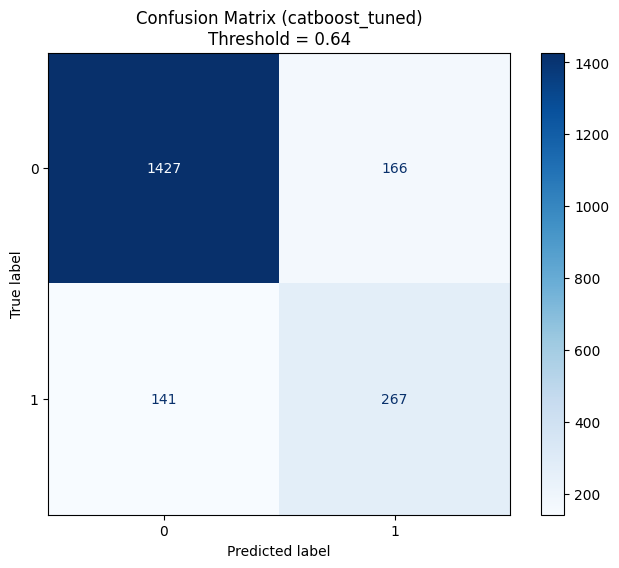

Бизнес-интерпретация:
   Правильно предсказали лояльных: 1427 клиентов
   Ложные срабатывания (напрасно беспокоили): 166 клиентов
   Пропущенные уходящие: 141 клиентов
   Правильно найденные уходящие: 267 клиентов


In [8]:
trainer.plot_confusion_matrix_final('catboost_tuned', threshold=0.640)

## 6. Анализ Confusion Matrix и Feature Importance

**Confusion Matrix (Матрица ошибок)**:

| Фактические значения | Положительные | Отрицательные |
| ------------ | ------------- | ------------- |
| **Предсказания** |            |            |
| Положительные | TP            | FP            | 
| Отрицательные | FN            | TN            |


**Интерпретация для нашей задачи**:
- **TP (True Positive)**: Правильно предсказанные уходящие клиенты
- **FP (False Positive)**: Ложные срабатывания (лояльные клиенты, предсказанные как уходящие)
- **FN (False Negative)**: Пропущенные уходящие клиенты (уходящие клиенты, предсказанные как лояльные)
- **TN (True Negative)**: Правильно предсказанные лояльные клиенты

* Правильно предсказали лояльных: 1427 клиентов
* Ложные срабатывания (лояльные клиенты, предсказанные как уходящие): 166 клиентов
* Пропущенные уходящие (уходящие клиенты, предсказанные как лояльные): 141 клиентов
* Правильно найденные уходящие: 267 клиентов

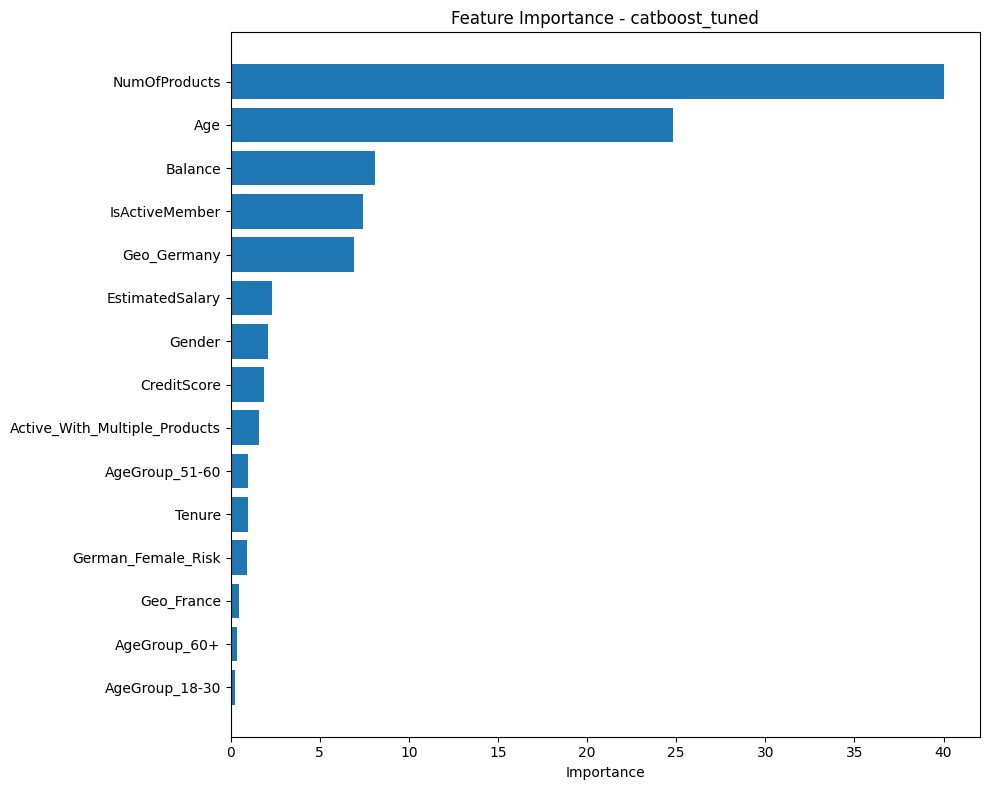

Топ-10 самых важных признаков:
   1. NumOfProducts: 40.0423
   2. Age: 24.8209
   3. Balance: 8.1228
   4. IsActiveMember: 7.4561
   5. Geo_Germany: 6.9165
   6. EstimatedSalary: 2.3223
   7. Gender: 2.1238
   8. CreditScore: 1.8492
   9. Active_With_Multiple_Products: 1.5740
   10. AgeGroup_51-60: 0.9956


In [9]:
trainer.plot_feature_importance('catboost_tuned')

## 7. Feature Importance

**Feature Importance (Важность признаков)**:
- **Метод расчета**: Среднее уменьшение примеси (Gini критерий)
- **Интерпретация**: Насколько каждый признак улучшает качество разделения
- **Бизнес-ценность**: Позволяет понять ключевые признаки оттока

**Топ-5 самых важных признаков**:

1. **NumOfProducts** - количество продуктов банка  
2. **Age** - возраст клиента
3. **Balance** - баланс на счете
4. **IsActiveMember** - активность клиента
5. **Geography_Germany** - географическое положение

**Выводы из анализа важности признаков**:
- Демографические факторы (возраст) важны, вклад признака - 24%
- Поведенческие метрики (активность, продукты) больше всего влияют на отток
- Географический фактор подтверждает EDA выводы о Германии

# Этап 5: Моделирование и эксперименты - выводы

## Цели этапа

В ходе проведения этапа № 5 были выполнены следующие цели:

1. Обучили и сравнили различные ML-алгоритмы
2. Провели подбор гиперпараметров для лучших моделей
3. Выбрали оптимальную модель для прогнозирования оттока
4. Проанализировали переобучение и стабильность моделей

### Использованные алгоритмы:
- **Базовые**: Logistic Regression, K-Neighbors, Decision Tree
- **Ансамбли**: Random Forest, XGBoost, LightGBM, CatBoost
- **Оптимизация**: Optuna для подбора гиперпараметров

### Процесс экспериментов:
1. **Базовое сравнение** - оценка 7 алгоритмов на кросс-валидации
2. **Гиперпараметрический поиск** - Optuna для CatBoost и LightGBM (100 trials)
3. **Анализ переобучения** - сравнение метрик на train/test данных
4. **Оптимизация порога** - поиск оптимального порога классификации

## Результаты экспериментов

### Сравнительная таблица моделей:
| Модель | Test ROC-AUC | Test F1 | Переобучение (AUC diff) |
|--------|--------------|---------|-------------------------|
| **CatBoost (тюнинг)** | **0.8720** | **0.6350** | **0.0183** |
| LightGBM (тюнинг) | 0.8633 | 0.5893 | 0.0296 |
| CatBoost (базовый) | 0.8628 | 0.5901 | 0.1003 |
| Random Forest | 0.8468 | 0.5807 | 0.1532 |
| LightGBM (базовый) | 0.8455 | 0.5722 | 0.1412 |

### Финальные метрики лучшей модели:
```python
Best Model: CatBoostClassifier (tuned)
ROC-AUC: 0.8720          # Отличное качество разделения
F1-Score: 0.6350         # Хороший баланс precision/recall  
Precision: 0.6166        # 62% точности предсказаний
Recall: 0.6544           # Обнаружено 65% уходящих клиентов
Optimal Threshold: 0.640 # Для максимизации F1-score